In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)                  
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax): ###graphbasedslam2draw
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)

def draw(xs, zlist, edges): #引数追加
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
    draw_edges(edges, ax) #追加
    plt.show()

In [3]:
def read_data():#データの読み込み
    hat_xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
    zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）

    with open("log.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": #姿勢のレコードの場合
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": #センサ値のレコードの場合
                if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
                
        return hat_xs, zlist

In [4]:
class ObsEdge: ###graphbasedslam3errorfunc
    def __init__(self, t1, t2, z1, z2, xs):
        assert z1[0] == z2[0] 

        self.t1, self.t2 = t1, t2  
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]
        
        s1 = math.sin(self.x1[2] + self.z1[1])   #ここから以下追加
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        
        ##残差の計算##
        hat_e = self.x2 - self.x1 + np.array([
            self.z2[0]*c2 - self.z1[0]*c1, 
            self.z2[0]*s2 - self.z1[0]*s1,
            self.z2[1] - self.z2[2] - self.z1[1] + self.z1[2]
        ])
        while hat_e[2] >= math.pi: hat_e[2] -= math.pi*2
        while hat_e[2] <  -math.pi: hat_e[2] += math.pi*2
            
        print(hat_e)

In [5]:
import itertools
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {} #ランドマークのIDをキーにして観測された時刻とセンサ値を記録

    for step in zlist:           #キーを時刻からランドマークのIDへ
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2)) #時刻のペアを作成
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges

[1.53105328 2.22864869 0.54029833]
[0.8789988  2.19975072 0.62992372]
[1.84308535 2.23505618 0.50863914]
[1.61644797 2.10939234 0.51052853]
[1.36521648 2.44693161 0.54922642]
[1.50994729 2.52558306 0.62219601]
[1.42124156 2.35093403 0.57992473]
[1.24550789 2.41785238 0.77773629]
[2.00327134 5.02926047 1.08205969]
[1.55312399 4.84367923 1.15580344]
[0.44001367 4.75531571 1.31719878]
[0.27748548 4.79548589 1.33306592]
[0.14587544 4.9867497  1.47661254]
[0.39587445 4.47313248 1.27480494]
[0.63446764 4.93446492 1.22273338]
[-0.65205448 -0.02889797  0.08962539]
[ 0.31203207  0.00640749 -0.03165919]
[ 0.08539469 -0.11925635 -0.0297698 ]
[-0.1658368   0.21828292  0.00892809]
[-0.021106    0.29693437  0.08189768]
[-0.10981172  0.12228533  0.03962641]
[-0.2855454   0.18920369  0.23743796]
[0.47221805 2.80061178 0.54176136]
[0.0220707  2.61503054 0.61550512]
[-1.09103962  2.52666702  0.77690045]
[-1.25356781  2.5668372   0.79276759]
[-1.38517785  2.75810101  0.93631422]
[-1.13517884  2.24448379 

<IPython.core.display.Javascript object>


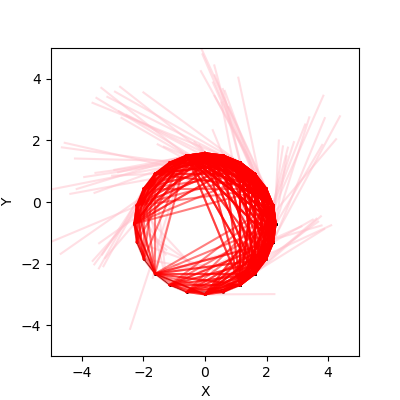

In [6]:
hat_xs, zlist = read_data()  ###graphbasedslam3exec
edges = make_edges(hat_xs, zlist)
draw(hat_xs, zlist, edges)